## CNN  en sepecifier une station

In [14]:
from tensorflow.keras import  layers, models, callbacks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.pipeline import Pipeline




## CNN  pour toute stations

In [8]:



file_path = 'merge_bikes_filtered_weather_data_filtered.csv'
data = pd.read_csv(file_path)
# prepa de data, add time categorie
data['timestamp'] = pd.to_datetime(data['timestamp'], format='mixed', errors='coerce')
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek  
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
data = data.set_index('timestamp')

# traite data train test

'''
numeric_features = ['hour','day_of_week','current_temperature', 'percentage_humidity', 'lat', 'lng','percentage_cloud_coverage','visibility_distance','feels_like_temperature']
binary_features = ['is_weekend', 'is_rainy','status']
categorical_features = ['number']
all_features = numeric_features + binary_features + categorical_features

preprocessor = ColumnTransformer(
    transformers=[
        ('time', Pipeline([
            ('scaler', MinMaxScaler())
        ]), ['hour', 'day_of_week']),
        ('weather', Pipeline([
            ('scaler', StandardScaler())
        ]), ['current_temperature', 'percentage_humidity', 
             'percentage_cloud_coverage', 'visibility_distance', 
             'feels_like_temperature']),
        ('location', Pipeline([
            ('scaler', MinMaxScaler())
        ]), ['lat', 'lng']),
        ('binary', 'passthrough', binary_features),
        
        ('id','passthrough',categorical_features )
    ]
)
'''
features_to_exclude = ['is_weekend', 'is_rainy', 'status', 'hour', 'day_of_week', 'number', 'available_bikes', 'available_bike_stands']
feature = [col for col in data.columns if col not in features_to_exclude]

scaler=MinMaxScaler()
data[feature] = scaler.fit_transform(data[feature]) 
scaler_y = MinMaxScaler()
data['available_bikes'] = scaler_y.fit_transform(data[['available_bikes']])

## test split :
grouped = data.groupby('number') 

train_data = []
test_data = []

test_ratio = 0.2 

for station, group in grouped:
    group = group.sort_index() 
    train_size = int(len(group) * (1 - test_ratio)) 
    train_data.append(group.iloc[:train_size])  
    test_data.append(group.iloc[train_size:])
  


train_data = pd.concat(train_data)
test_data = pd.concat(test_data)


print(f"nombre de train data：{len(train_data)}")
print(f"nombre de test data: {len(test_data)}")


X_train=(train_data.drop(columns=['available_bikes','available_bike_stands']).values)
X_train=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
y_train=train_data['available_bikes'].values
X_test=train_data.drop(columns=['available_bikes','available_bike_stands']).values
X_test=X_test.reshape(X_test.shape[0],1,X_test.shape[1])
y_test=train_data['available_bikes'].values
print(f"Total unique stations in data: {data['number'].nunique()}")
print("x_train shape: ")
print(X_train.shape)
print("y_train shape: ")
print(y_train.shape)
print("x_test shape: ")
print(X_test.shape)
print("y_test shape: ")
print(y_test.shape)
print(grouped.get_group(1).describe())


nombre de train data：913265
nombre de test data: 228602
Total unique stations in data: 382
x_train shape: 
(913265, 1, 13)
y_train shape: 
(913265,)
x_test shape: 
(913265, 1, 13)
y_test shape: 
(913265,)
       number          lat         lng  status  available_bike_stands  \
count  2997.0  2997.000000  2997.00000  2997.0            2997.000000   
mean      1.0     0.491064     0.88022     1.0              12.171171   
std       0.0     0.000000     0.00000     0.0               6.313389   
min       1.0     0.491064     0.88022     1.0               0.000000   
25%       1.0     0.491064     0.88022     1.0               7.000000   
50%       1.0     0.491064     0.88022     1.0              15.000000   
75%       1.0     0.491064     0.88022     1.0              18.000000   
max       1.0     0.491064     0.88022     1.0              19.000000   

       available_bikes  percentage_cloud_coverage  visibility_distance  \
count      2997.000000                2997.000000          2997

In [4]:

print(train_data.drop(columns=['available_bikes','available_bike_stands']).columns.to_list())
print(X_train[:5])  

['number', 'lat', 'lng', 'status', 'percentage_cloud_coverage', 'visibility_distance', 'percentage_humidity', 'current_temperature', 'feels_like_temperature', 'is_rainy', 'hour', 'day_of_week', 'is_weekend']
[[[ 1.          0.49106365  0.88022032  1.          1.
    1.          0.64150943  0.47619048  0.55930872  0.
   18.          2.          0.        ]]

 [[ 1.          0.49106365  0.88022032  1.          1.
    1.          0.66981132  0.46428571  0.54251767  0.
   18.          2.          0.        ]]

 [[ 1.          0.49106365  0.88022032  1.          1.
    1.          0.69811321  0.45238095  0.52572663  0.
   18.          2.          0.        ]]

 [[ 1.          0.49106365  0.88022032  1.          1.
    1.          0.72641509  0.44047619  0.50893559  0.
   18.          2.          0.        ]]

 [[ 1.          0.49106365  0.88022032  1.          1.
    1.          0.75471698  0.42857143  0.49214454  0.
   19.          2.          0.        ]]]


In [9]:
model = models.Sequential([
    layers.Conv1D(filters=16, kernel_size=1, padding='causal',activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.BatchNormalization(),
    layers.Conv1D(
            filters=64,
            kernel_size=2,
            padding='causal',
            activation='relu'
        ),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='linear')  
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 16)             224       
                                                                 
 batch_normalization (Batch  (None, 1, 16)             64        
 Normalization)                                                  
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             2112      
                                                                 
 batch_normalization_1 (Bat  (None, 1, 64)             256       
 chNormalization)                                                
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [10]:
print("Training the model...")
callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]
history = model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=128,
    shuffle=False,
    callbacks=[callbacks] 
)



Training the model...
Epoch 1/30
6422/6422 [==============================] - 57s 8ms/step - loss: 0.0132 - mae: 0.0887 - val_loss: 0.2190 - val_mae: 0.1992 - lr: 0.0010
Epoch 2/30
6422/6422 [==============================] - 44s 7ms/step - loss: 0.0117 - mae: 0.0864 - val_loss: 0.0075 - val_mae: 0.0720 - lr: 0.0010
Epoch 3/30
6422/6422 [==============================] - 67s 10ms/step - loss: 0.0117 - mae: 0.0864 - val_loss: 0.0077 - val_mae: 0.0742 - lr: 0.0010
Epoch 4/30
6422/6422 [==============================] - 59s 9ms/step - loss: 0.0117 - mae: 0.0865 - val_loss: 0.0086 - val_mae: 0.0780 - lr: 0.0010
Epoch 5/30
6422/6422 [==============================] - 56s 9ms/step - loss: 0.0117 - mae: 0.0866 - val_loss: 0.0167 - val_mae: 0.1056 - lr: 5.0000e-04


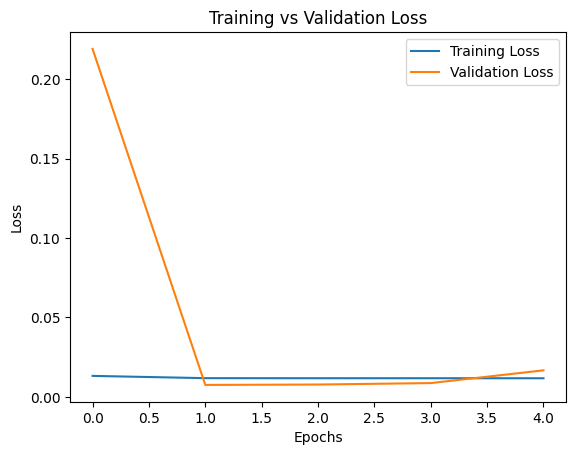

In [11]:


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

In [12]:
predictions = model.predict( X_test)
r2 = r2_score(y_test, predictions)
print("R² Score:", r2)

28540/28540 [==============================] - 90s 3ms/step
R² Score: -0.020718208463458065


LSTM

train shape: (911737, 4, 15)
test shape: (227076, 4, 15)
Epoch 1/30
11397/11397 [==============================] - 347s 29ms/step - loss: 0.0077 - mae: 0.0592 - val_loss: 0.0053 - val_mae: 0.0593 - lr: 0.0010
Epoch 2/30
11397/11397 [==============================] - 275s 24ms/step - loss: 0.0041 - mae: 0.0477 - val_loss: 0.0023 - val_mae: 0.0368 - lr: 0.0010
Epoch 3/30
11397/11397 [==============================] - 250s 22ms/step - loss: 0.0037 - mae: 0.0445 - val_loss: 0.0028 - val_mae: 0.0427 - lr: 0.0010
Epoch 4/30
11397/11397 [==============================] - 250s 22ms/step - loss: 0.0034 - mae: 0.0429 - val_loss: 0.0030 - val_mae: 0.0435 - lr: 0.0010
Epoch 5/30
11397/11397 [==============================] - 315s 28ms/step - loss: 0.0033 - mae: 0.0422 - val_loss: 0.0024 - val_mae: 0.0370 - lr: 0.0010
Epoch 6/30
11397/11397 [==============================] - 325s 28ms/step - loss: 0.0033 - mae: 0.0420 - val_loss: 0.0032 - val_mae: 0.0431 - lr: 5.0000e-04
Epoch 7/30
11397/11397 [===

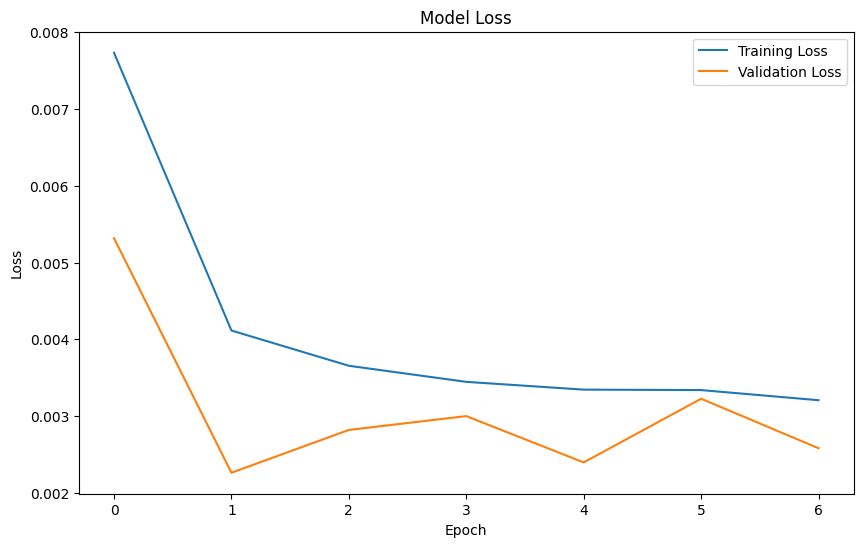

7097/7097 [==============================] - 57s 8ms/step

Model Performance:
R² Score: -0.9638
MAE: 0.1052


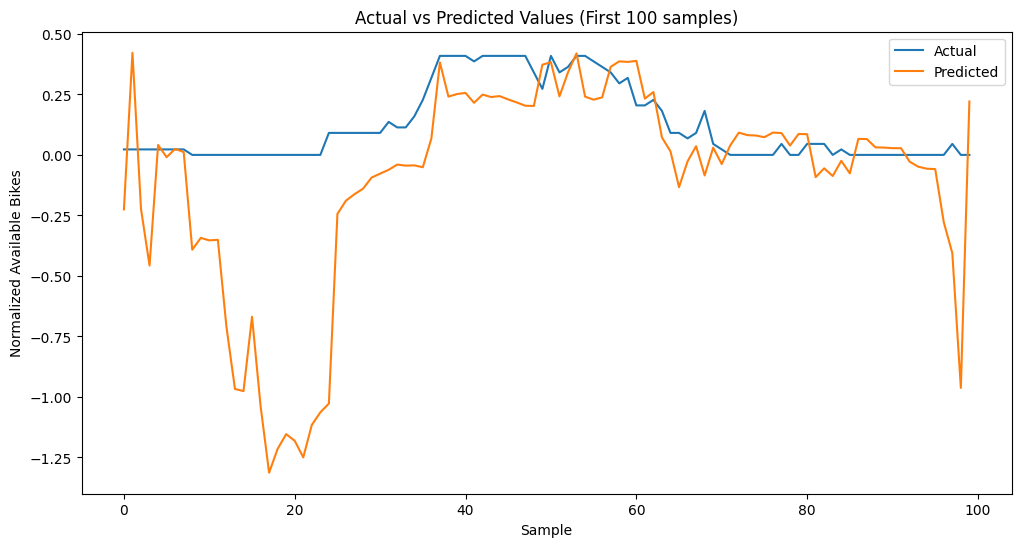

In [15]:
def create_sequences(data, window_size, target_col='available_bikes'):
    X = []
    y = []
    grouped = data.groupby('number')
    
    for _, group in grouped:
        group = group.sort_index()
        sequences = []
        targets = []
        
        for i in range(len(group) - window_size):
            sequences.append(group.iloc[i:i + window_size].values)
            targets.append(group.iloc[i + window_size][target_col])
            
        X.extend(sequences)
        y.extend(targets)
    
    return np.array(X), np.array(y)
X_train, y_train = create_sequences(train_data, 4)
X_test, y_test = create_sequences(test_data, 4)
print(f"train shape: {X_train.shape}")
print(f"test shape: {X_test.shape}")
model = models.Sequential([
    layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.BatchNormalization(),
    layers.LSTM(32),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

history = model.fit(
        X_train,
        y_train,
        validation_split=0.2,
        epochs=30,
        batch_size=64,
        callbacks=callbacks_list,
        shuffle=False
    )

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

predictions = model.predict(X_test)

r2 = r2_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'\nModel Performance:')
print(f'R² Score: {r2:.4f}')
print(f'MAE: {mae:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test[:100], label='Actual')
plt.plot(predictions[:100], label='Predicted')
plt.title('Actual vs Predicted Values (First 100 samples)')
plt.xlabel('Sample')
plt.ylabel('Normalized Available Bikes')
plt.legend()
plt.show()